In [1]:
# Importing all the required Libraries 
import math
import statistics as s
import scipy.stats as scs
import pandas as pd
import numpy as np
import numpy.random as npr
import yfinance as yf
from pylab import plt
from pylab import mpl
import scipy.optimize as sco
import datetime as dt

In [2]:
################################################################################################################################
################################               Define Varaibles               ##################################################
################################################################################################################################

#Define Simulation Key Variables

Rf=0                                     #Risk Free Rate
simulations = 2500                       #Number of simulations to run
market='^GSPC'
extra_asset='ETH-USD'

# Date range
start = dt.datetime(2017,11,20)
end = dt.datetime(2022,2,28)
interval= '1d' # Change interval to weekly as ETH trades every day while normal exchanges do not

#Define Benchmark
benchmark_assets=['URTH','IEMG','VPU','VIS','VDE','VHT','VDC','VGT','VBIIX','VBMFX','DBC','VNQ','QALTX']
benchmark_assets.sort()

#Define Portfolio
portfolio_assets=['ETH-USD','URTH','IEMG','VPU','VIS','VDE','VHT','VDC','VGT','VBIIX','VBMFX','DBC','VNQ','QALTX']
portfolio_assets.sort()

#Define Market 
market_assets=['^GSPC','ETH-USD','URTH','IEMG','VPU','VIS','VDE','VHT','VDC','VGT','VBIIX','VBMFX','DBC','VNQ','QALTX'] #we use this to get market variance and covariance for each security
market_assets.sort()

benchmark_returns=[]                     #Benchmark Returns 
benchmark_stds=[]                        #Benchmark Volatility
benchmark_noa=len(benchmark_assets)      #Number of assets in the Benchmark
benchmark_weights_list=[]

portfolio_returns=[]                     #Portfolio Returns 
portfolio_stds=[]                        #Portfolio Volatility
portfolio_noa=len(portfolio_assets)      #Number of assets in the Portfolio
portfolio_weights_list=[]

market_returns=[]                        #Market Returns 
market_var=[]                            #Market Variance

# Market and Porfolio information

market_location=market_assets.index(market)  #Identifies the location of the market reference within the list
market_covariances=[]
market_cov_list=[]
portfolio_betas=[]
benchmark_betas=[]
benchmark_sr_list=[]
portfolio_sr_list=[]
benchmark_tr_list=[]
portfolio_tr_list=[]
benchmark_alpha_list=[]
portfolio_alpha_list=[]
beta_list=[]
betas=[]




In [3]:
################################################################################################################################
################################               Define Functions               ##################################################
################################################################################################################################


# general return and volatility functions ####### NOTE CHANGE FORMULA TO ACCOUNT FOR WEEKLY RETURNS FOR THE THESIS #####

#Function for Benchmark Return and Standard Deviation
def benchmark_return(weights):
    return np.sum(benchmark_rets.mean()*weights)*252  # Adjust the formula to account for weekly returns?????

def benchmark_std(weights):
    return np.sqrt(np.dot(weights.T,np.dot(benchmark_rets.cov()*252,weights))) # Adjust the formula to account for weekly returns?????

def portfolio_return(weights):
    return np.sum(portfolio_rets.mean()*weights)*252  # Adjust the formula to account for weekly returns?????

def portfolio_std(weights):
    return np.sqrt(np.dot(weights.T,np.dot(portfolio_rets.cov()*252,weights))) # Adjust the formula to account for weekly returns?????

def min_portfolio_sharpe(weights):
    return -portfolio_return(weights)/portfolio_std(weights) #function to be minimized # Negative sign as we want to maximize Sharpe Ratio

def min_benchmark_sharpe(weights):
    return -benchmark_return(weights)/benchmark_std(weights) #function to be minimized # Negative sign as we want to maximize Sharpe Ratio

def Beta(cov,var): #Computing the Beta of each observation
    return cov/var # cov(i,m)/var(m)

def p_beta(weights,beta):
    return np.sum(beta*weights) # computing the beta of a portfolio of assets

def sharpe_ratio(Rf,R,std):  # Defining the function to calculate the Sharpe Ratio
    return (R-Rf)/std

def treynor_ratio(Rf,R,B):  # Defining the function to calculate the Treynor Ratio
    return (R-Rf)/B

def jensens_alpha(Rf,Rm,R,B):  # Defining the function to calculate the Jensen's Alpha
    return R-(Rf+B*(Rm-Rf))


def check_sum(weights):       #fucntion to check if allocation sums to 1
    return np.sum(weights)-1



In [4]:
################################################################################################################################
################################                    Download                    ################################################
################################################################################################################################

#Download the Benchmark Data from Yahoo Finance
benchmark_data = yf.download(benchmark_assets, start = start, end = end, interval=interval)
benchmark_data = benchmark_data.loc[:,('Adj Close', slice(None))]
benchmark_data.columns = benchmark_assets
benchmark_nb_rows=benchmark_data.shape[0]

#Download the Portfolio Data from Yahoo Finance
portfolio_data = yf.download(portfolio_assets, start = start, end = end, interval=interval)
portfolio_data = portfolio_data.loc[:,('Adj Close', slice(None))]
portfolio_data.columns = portfolio_assets
portfolio_nb_rows=portfolio_data.shape[0]

#Download the Market Benchmark Data from Yahoo Finance
market_data = yf.download(market_assets, start = start, end = end, interval=interval)
market_data = market_data.loc[:,('Adj Close', slice(None))]
market_data.columns = market_assets
market_nb_rows=market_data.shape[0]






[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  15 of 15 completed


In [5]:
################################################################################################################################
################################                   Basic Computations                     ######################################
################################################################################################################################

#Calculating the rate of return from data
benchmark_rets=np.log(benchmark_data/benchmark_data.shift(1)) #Calculating return of the Benchmark data using log difference
portfolio_rets=np.log(portfolio_data/portfolio_data.shift(1)) #Calculating return of the Portfolio data using log difference
market_rets=np.log(market_data/market_data.shift(1)) #Calculating return of the Market data using log difference

#calculating the average historical return of the market portfolio
market_returns=market_rets.mean()*252 #Note make sure to annualize properly, and location for alpha

# NOTE: Other Returns Computations are conducted within the Monte Carlo Simulation Loop for efficiency

#Computing the covariances, note that cov(x,x)=var(x)
benchmark_covs=benchmark_rets.cov()
portfolio_covs=portfolio_rets.cov()
market_covs=market_rets.cov()

#looping to get covariances in a list in the order they are sorted, check the .head() for reference
j=0
for a in market_assets: 
    market_covariances.append(market_covs.loc[market_assets[market_location],market_assets[j]])
    print(market_assets[j]) 
    market_cov_list.append([market_assets[j],market_covs.loc[market_assets[market_location],market_assets[j]]]) #sets a 2 dimensional array asset name + covariance with market
    j=j+1

print(market_covariances)
print(market_cov_list)     

#Computing Beta of each security # Note that i=position of the market
k=0
for ma in market_assets: #looping to get covariances and compute beta
    betas.append(Beta(market_cov_list[k][1],market_cov_list[market_location][1])) #assigns beta values without names
    beta_list.append([market_assets[k],Beta(market_cov_list[k][1],market_cov_list[market_location][1])])#sets a 2 dimensional array asset name + beta
    k=k+1

betas_port_copy=list.copy(betas)
del betas_port_copy[market_location]

extra_asset_location=market_assets.index(extra_asset)    # Identifying the extra asset in the portfolio
betas_bench_copy=list.copy(betas_port_copy)
del betas_bench_copy[extra_asset_location]               # Removing the extra asset in the portfolio

################################################################################################################################
################################                Monte Carlo Simulation                    ######################################
################################################################################################################################

#Using monte carlo to generate random portfolio weights
#The for iteration is the monte carlo simulaion for the weights

for b in range (simulations):
    benchmark_weights = np.random.random(benchmark_noa)
    benchmark_weights /= np.sum(benchmark_weights)
    benchmark_returns.append(benchmark_return(benchmark_weights))
    benchmark_stds.append(benchmark_std(benchmark_weights))
    benchmark_weights_list.append(benchmark_weights)


for p in range (simulations):
    portfolio_weights = np.random.random(portfolio_noa)
    portfolio_weights /= np.sum(portfolio_weights)
    portfolio_returns.append(portfolio_return(portfolio_weights))
    portfolio_stds.append(portfolio_std(portfolio_weights))
    portfolio_weights_list.append(portfolio_weights)


################################################################################################################################
################################                   Metric Computations                     ######################################
################################################################################################################################

#Computing Benchmark Metrics

benchmark_returns = np.array(benchmark_returns)
benchmark_stds = np.array(benchmark_stds)
benchmark_weights_list=np.array(benchmark_weights_list)
benchmark_betas = np.dot(benchmark_weights_list,betas_bench_copy) # Calculating the Benchmark Betas

#Computing Portfolio Metrics
portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)
portfolio_weights_list=np.array(portfolio_weights_list)
portfolio_betas = np.dot(portfolio_weights_list,betas_port_copy) # Calculating the Portfolio Betas


# In this section we will compute performance metrics for the benchmark and portfolio 

i=0
for s in range (simulations):
    #sharpe_ratio
    benchmark_sr=sharpe_ratio(Rf,benchmark_returns[i],benchmark_stds[i])
    benchmark_sr_list.append(benchmark_sr) # list of benchmark sharpe ratios
    portfolio_sr=sharpe_ratio(Rf,portfolio_returns[i],portfolio_stds[i])
    portfolio_sr_list.append(portfolio_sr) # list of portfolio sharpe ratios
    
    #treynor_ratio
    benchmark_tr=treynor_ratio(Rf,benchmark_returns[i],benchmark_betas[i])
    benchmark_tr_list.append(benchmark_tr) # list of benchmark sharpe ratios
    portfolio_tr=treynor_ratio(Rf,portfolio_returns[i],portfolio_betas[i])
    portfolio_tr_list.append(portfolio_tr)
    
    #Jensen's Alpha
    benchmark_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_returns[i],benchmark_betas[i])
    benchmark_alpha_list.append(benchmark_alpha) # list of benchmark sharpe ratios
    portfolio_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_returns[i],portfolio_betas[i])
    portfolio_alpha_list.append(portfolio_alpha)
    i=i+1
    

DBC
ETH-USD
IEMG
QALTX
URTH
VBIIX
VBMFX
VDC
VDE
VGT
VHT
VIS
VNQ
VPU
^GSPC
[5.320230789570675e-05, 0.00019749670198447052, 0.0001327056942289367, 5.303755348471703e-05, 0.00014603038642581036, -5.835528094610331e-06, -5.14609237550392e-06, 0.00010690119668778497, 0.0001802494075894024, 0.0001863136020819958, 0.0001353672920647114, 0.00016505273269472236, 0.00013467640582687327, 0.00010951031381651675, 0.00015763984399597407]
[['DBC', 5.320230789570675e-05], ['ETH-USD', 0.00019749670198447052], ['IEMG', 0.0001327056942289367], ['QALTX', 5.303755348471703e-05], ['URTH', 0.00014603038642581036], ['VBIIX', -5.835528094610331e-06], ['VBMFX', -5.14609237550392e-06], ['VDC', 0.00010690119668778497], ['VDE', 0.0001802494075894024], ['VGT', 0.0001863136020819958], ['VHT', 0.0001353672920647114], ['VIS', 0.00016505273269472236], ['VNQ', 0.00013467640582687327], ['VPU', 0.00010951031381651675], ['^GSPC', 0.00015763984399597407]]


In [6]:
################################################################################################################################
################################                 Optimization Process                     ######################################
################################################################################################################################

##OPTIMIZING THE PORTFOLIO 

#Setting the optimization conditions
portfolio_cons=({'type': 'eq','fun':check_sum}) #Constraint 
portfolio_bounds = tuple((0,1) for x in range(portfolio_noa)) #Bounderies, note that they be a squence of parameters rather than just 1
portfolio_eweights = np.array(portfolio_noa*[1./portfolio_noa,]) # setting equal weights as an initial estimation

#Optimization Command
portfolio_optimization=sco.minimize(min_portfolio_sharpe,portfolio_eweights,method='SLSQP',bounds=portfolio_bounds,constraints=portfolio_cons)  

#Results    
portfolio_opt_weights=portfolio_optimization['x'].round(3) #calculating the Optimal Portfolio weights 
portfolio_opt_return=portfolio_return(portfolio_opt_weights) #Calculating the return of the Optimal Portfolio
portfolio_opt_std=portfolio_std(portfolio_opt_weights) #Calculating the volatility of the Optimal Portfolio
portfolio_opt_beta=p_beta(portfolio_opt_weights,betas_port_copy)#Calculating the Beta of the Optimal Portfolio
portfolio_opt_sr=sharpe_ratio(Rf,portfolio_opt_return,portfolio_opt_std) #Calculating the Sharpe Ratio of the Optimal Portfolio
portfolio_opt_tr=treynor_ratio(Rf,portfolio_opt_return,portfolio_opt_beta)#Calculating the treynor Ratio of the Optimal Portfolio
portfolio_opt_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_opt_return,portfolio_opt_beta)#Calculating the Alpha of the Optimal Portfolio

#Calculating the Minimum Variance Portfolio 

portfolio_minvar=sco.minimize(portfolio_std,portfolio_eweights,method='SLSQP',bounds=portfolio_bounds,constraints=portfolio_cons) 

#Results    
portfolio_minvar_weights=portfolio_minvar['x'].round(3) #calculating the Minimuim Variance Portfolio weights 
portfolio_minvar_return=portfolio_return(portfolio_minvar_weights) #Calculating the return of the Minimuim Variance Portfolio
portfolio_minvar_std=portfolio_std(portfolio_minvar_weights) #Calculating the volatility of the Minimuim Variance Portfolio
portfolio_minvar_beta=p_beta(portfolio_minvar_weights,betas_port_copy)#Calculating the Beta of the Minimuim Variance Portfolio
portfolio_minvar_sr=sharpe_ratio(Rf,portfolio_minvar_return,portfolio_minvar_std) #Calculating the Sharpe Ratio of the Minimuim Variance Portfolio
portfolio_minvar_tr=treynor_ratio(Rf,portfolio_minvar_return,portfolio_minvar_beta)#Calculating the treynor Ratio of the Minimuim Variance Portfolio
portfolio_minvar_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_minvar_return,portfolio_minvar_beta)#Calculating the Alpha  the Minimuim Variance Portfolio


#Calculating the Naive portfolio (portfolio with equal weights)
portfolio_naive_weights=portfolio_eweights #calculating the Naive Benchmark weights 
portfolio_naive_return=portfolio_return(portfolio_naive_weights) #Calculating the return of the Naive Benchmark
portfolio_naive_std=portfolio_std(portfolio_naive_weights) #Calculating the volatility of the Naive Benchmark
portfolio_naive_beta=p_beta(portfolio_naive_weights,betas_port_copy)#Calculating the Beta of the Naive Benchmark
portfolio_naive_sr=sharpe_ratio(Rf,portfolio_naive_return,portfolio_naive_std) #Calculating the Sharpe Ratio of the Naive Benchmark
portfolio_naive_tr=treynor_ratio(Rf,portfolio_naive_return,portfolio_naive_beta)#Calculating the treynor Ratio of the Naive Benchmark
portfolio_naive_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_naive_return,portfolio_naive_beta)#Calculating the Alpha the Naive Benchmark


# OPTIMIZING THE BENCHMARK

#Setting the optimization conditions
benchmark_cons=({'type': 'eq','fun':check_sum}) #Constraint 
benchmark_bounds = tuple((0,1) for x in range(benchmark_noa)) #Bounderies, note that they be a squence of parameters rather than just 1
benchmark_eweights = np.array(benchmark_noa*[1./benchmark_noa,]) # setting equal weights as an initial estimation

#Optimization Command
benchmark_optimization=sco.minimize(min_benchmark_sharpe,benchmark_eweights,method='SLSQP',bounds=benchmark_bounds,constraints=benchmark_cons)  

#Results    
benchmark_opt_weights=benchmark_optimization['x'].round(3) #calculating the Optimal Portfolio weights 
benchmark_opt_return=benchmark_return(benchmark_opt_weights) #Calculating the return of the Optimal Portfolio
benchmark_opt_std=benchmark_std(benchmark_opt_weights) #Calculating the volatility of the Optimal Portfolio
benchmark_opt_beta=p_beta(benchmark_opt_weights,betas_bench_copy)#Calculating the Beta of the Optimal Portfolio
benchmark_opt_sr=sharpe_ratio(Rf,benchmark_opt_return,benchmark_opt_std) #Calculating the Sharpe Ratio of the Optimal Portfolio
benchmark_opt_tr=treynor_ratio(Rf,benchmark_opt_return,benchmark_opt_beta)#Calculating the treynor Ratio of the Optimal Portfolio
benchmark_opt_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_opt_return,benchmark_opt_beta)#Calculating the Alpha of the Optimal Portfolio

#Calculating the Minimum Variance Portfolio 
benchmark_minvar=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP',bounds=benchmark_bounds,constraints=benchmark_cons) 

#Results    
benchmark_minvar_weights=benchmark_minvar['x'].round(3) #calculating the Minimuim Variance Portfolio weights 
benchmark_minvar_return=benchmark_return(benchmark_minvar_weights) #Calculating the return of the Minimuim Variance Portfolio
benchmark_minvar_std=benchmark_std(benchmark_minvar_weights) #Calculating the volatility of the Minimuim Variance Portfolio
benchmark_minvar_beta=p_beta(benchmark_minvar_weights,betas_bench_copy)#Calculating the Beta of the Minimuim Variance Portfolio
benchmark_minvar_sr=sharpe_ratio(Rf,benchmark_minvar_return,benchmark_minvar_std) #Calculating the Sharpe Ratio of the Minimuim Variance Portfolio
benchmark_minvar_tr=treynor_ratio(Rf,benchmark_minvar_return,benchmark_minvar_beta)#Calculating the treynor Ratio of the Minimuim Variance Portfolio
benchmark_minvar_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_minvar_return,benchmark_minvar_beta)#Calculating the Alpha  the Minimuim Variance Portfolio

#Calculating the Naive Benchmark (Benchmakr with equal weights)
benchmark_naive_weights=benchmark_eweights #calculating the Naive Benchmark weights 
benchmark_naive_return=benchmark_return(benchmark_naive_weights) #Calculating the return of the Naive Benchmark
benchmark_naive_std=benchmark_std(benchmark_naive_weights) #Calculating the volatility of the Naive Benchmark
benchmark_naive_beta=p_beta(benchmark_naive_weights,betas_bench_copy)#Calculating the Beta of the Naive Benchmark
benchmark_naive_sr=sharpe_ratio(Rf,benchmark_naive_return,benchmark_naive_std) #Calculating the Sharpe Ratio of the Naive Benchmark
benchmark_naive_tr=treynor_ratio(Rf,benchmark_naive_return,benchmark_naive_beta)#Calculating the treynor Ratio of the Naive Benchmark
benchmark_naive_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_naive_return,benchmark_naive_beta)#Calculating the Alpha the Naive Benchmark


################################################################################################################################
################################                   Efficient Frontier                     ######################################
################################################################################################################################

# Plotting the Benchmark efficient Frontier 

benchmark_constraint_EF=({'type':'eq','fun': lambda x: benchmark_return(x)-target_return},{'type':'eq','fun': check_sum}) # Constraint
benchmark_bounds_EF= tuple((0,1) for x in benchmark_weights)        # Bounds

benchmark_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
benchmark_target_stds=[]                                   #Target Volatility Variable
for target_return in benchmark_target_returns:
    benchmark_res=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP', bounds=benchmark_bounds_EF, constraints=benchmark_constraint_EF)
    benchmark_target_stds.append(benchmark_res['fun'])
benchmark_target_stds=np.array(benchmark_target_stds)

# Plotting the Portfolio efficient Frontier 
portfolio_eweights = np.array(portfolio_noa*[1./portfolio_noa,])
portfolio_constraint_EF=({'type':'eq','fun': lambda x: portfolio_return(x)-target_return},{'type':'eq','fun': check_sum}) # Constraint
portfolio_bounds_EF= tuple((0,1) for x in portfolio_weights)        # Bounds

portfolio_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
portfolio_target_stds=[]                                   #Target Volatility Variable
for target_return in portfolio_target_returns:
    portfolio_res=sco.minimize(portfolio_std,portfolio_eweights,method='SLSQP', bounds=portfolio_bounds_EF, constraints=portfolio_constraint_EF)
    portfolio_target_stds.append(portfolio_res['fun'])
portfolio_target_stds=np.array(portfolio_target_stds)


In [7]:
################################################################################################################################
################################                  Compiling DataFrames                    ######################################
################################################################################################################################

#Generating DF for Portfolio
portfolio_weights_list_df=pd.DataFrame(portfolio_weights_list,columns=portfolio_assets) #Trasnforming arrays to a dataframe
portfolio_returns_df = pd.DataFrame(portfolio_returns,columns=["portfolio_returns"])
portfolio_stds_df = pd.DataFrame(portfolio_stds,columns=["portfolio_stds"])

#Generating DF for Benchmark
benchmark_weights_list_df=pd.DataFrame(benchmark_weights_list,columns=benchmark_assets) #Trasnforming arrays to a dataframe
benchmark_returns_df = pd.DataFrame(benchmark_returns,columns=["benchmark_returns"])
benchmark_stds_df = pd.DataFrame(benchmark_stds,columns=["benchmark_stds"])

#Betas
benchmark_betas_df = pd.DataFrame(benchmark_betas,columns=["Benchmak Beta Values"])
portfolio_betas_df = pd.DataFrame(portfolio_betas,columns=["Portfolio Beta Values"])

#Sharpe Ratios
benchmark_sr_df = pd.DataFrame(benchmark_sr_list,columns=["benchmark_sharpe"])
portfolio_sr_df = pd.DataFrame(portfolio_sr_list,columns=["portfolio_sharpe"])

#Tryenor Ratios
benchmark_tr_df = pd.DataFrame(benchmark_tr_list,columns=["benchmark_treynor"])
portfolio_tr_df = pd.DataFrame(portfolio_tr_list,columns=["portfolio_treynor"])

#Jensen's Alpha
benchmark_alpha_df = pd.DataFrame(benchmark_alpha_list,columns=["benchmark_alpha"])
portfolio_alpha_df = pd.DataFrame(portfolio_alpha_list,columns=["portfolio_alpha"])

#Summarizing the data into a single data frame 
benchmark_df=pd.concat([benchmark_weights_list_df,benchmark_returns_df,benchmark_stds_df,benchmark_betas_df,benchmark_sr_df,benchmark_tr_df,benchmark_alpha_df],axis=1)
portfolio_df=pd.concat([portfolio_weights_list_df,portfolio_returns_df,portfolio_stds_df,portfolio_betas_df,portfolio_sr_df,portfolio_tr_df,portfolio_alpha_df],axis=1)

################################################################################################################################
################################                 Optimization DataFrames                  ######################################
################################################################################################################################

#Defining metrics for dictionary keys
metrics=["Return","Std","Beta","Sharpe","Treynor","Alpha"]

# Creating Optimal portfolio Dataframe
portfolio_opt_dict={}
portfolio_opt_keys=portfolio_assets
portfolio_opt_values=portfolio_opt_weights

portfolio_opt_dict=dict(zip(portfolio_opt_keys,portfolio_opt_values))  #Creating Dictionary

portfolio_opt_metrics=[portfolio_opt_return,portfolio_opt_std,portfolio_opt_beta,portfolio_opt_sr,portfolio_opt_tr,portfolio_opt_alpha]
portfolio_opt_dict.update(dict(zip(metrics,portfolio_opt_metrics)))  #Adding metrics to Dictionar
     
portfolio_opt_df=pd.DataFrame(list(portfolio_opt_dict.items()))
portfolio_opt_df=portfolio_opt_df.set_index([0]).T
portfolio_opt_df.index=["Optimal Portfolio"]

# Creating Naive portfolio Dataframe

portfolio_naive_dict={}
portfolio_naive_keys=portfolio_assets
portfolio_naive_values=portfolio_naive_weights

portfolio_naive_dict=dict(zip(portfolio_naive_keys,portfolio_naive_values)) #Creating Dictionary

portfolio_naive_metrics=[portfolio_naive_return,portfolio_naive_std,portfolio_naive_beta,portfolio_naive_sr,portfolio_naive_tr,portfolio_naive_alpha]
portfolio_naive_dict.update(dict(zip(metrics,portfolio_naive_metrics)))  #Adding metrics to Dictionar
     
portfolio_naive_df=pd.DataFrame(list(portfolio_naive_dict.items()))
portfolio_naive_df=portfolio_naive_df.set_index([0]).T
portfolio_naive_df.index=["Naive Portfolio"]

# Creating Minimuim Variance portfolio Dataframe

portfolio_minvar_dict={}
portfolio_minvar_keys=portfolio_assets
portfolio_minvar_values=portfolio_minvar_weights

portfolio_minvar_dict=dict(zip(portfolio_minvar_keys,portfolio_minvar_values)) # Creating Dictionary

portfolio_minvar_metrics=[portfolio_minvar_return,portfolio_minvar_std,portfolio_minvar_beta,portfolio_minvar_sr,portfolio_minvar_tr,portfolio_minvar_alpha]
portfolio_minvar_dict.update(dict(zip(metrics,portfolio_minvar_metrics)))  #Adding metrics to Dictionar

portfolio_minvar_df=pd.DataFrame(list(portfolio_minvar_dict.items()))
portfolio_minvar_df=portfolio_minvar_df.set_index([0]).T
portfolio_minvar_df.index=["Minvar Portfolio"]


# Creating Optimal Benchmark Dataframe
benchmark_opt_dict={}
benchmark_opt_keys=benchmark_assets
benchmark_opt_values=benchmark_opt_weights

benchmark_opt_dict=dict(zip(benchmark_opt_keys,benchmark_opt_values))  #Creating Dictionary

benchmark_opt_metrics=[benchmark_opt_return,benchmark_opt_std,benchmark_opt_beta,benchmark_opt_sr,benchmark_opt_tr,benchmark_opt_alpha]
benchmark_opt_dict.update(dict(zip(metrics,benchmark_opt_metrics)))  #Adding metrics to Dictionar
     
benchmark_opt_df=pd.DataFrame(list(benchmark_opt_dict.items()))
benchmark_opt_df=benchmark_opt_df.set_index([0]).T
benchmark_opt_df.index=["Optimal Benchmark"]

# Creating Naive Benchmark Dataframe
benchmark_naive_dict={}
benchmark_naive_keys=benchmark_assets
benchmark_naive_values=benchmark_naive_weights

benchmark_naive_dict=dict(zip(benchmark_naive_keys,benchmark_naive_values))  #Creating Dictionary

benchmark_naive_metrics=[benchmark_naive_return,benchmark_naive_std,benchmark_naive_beta,benchmark_naive_sr,benchmark_naive_tr,benchmark_naive_alpha]
benchmark_naive_dict.update(dict(zip(metrics,benchmark_naive_metrics)))  #Adding metrics to Dictionar

benchmark_naive_df=pd.DataFrame(list(benchmark_naive_dict.items()))
benchmark_naive_df=benchmark_naive_df.set_index([0]).T
benchmark_naive_df.index=["Naive Benchmark"]

# Creating Minimuim Variance Benchmark Dataframe
benchmark_minvar_dict={}
benchmark_minvar_keys=benchmark_assets
benchmark_minvar_values=benchmark_minvar_weights

benchmark_minvar_dict=dict(zip(benchmark_minvar_keys,benchmark_minvar_values))  #Creating Dictionary

benchmark_minvar_metrics=[benchmark_minvar_return,benchmark_minvar_std,benchmark_minvar_beta,benchmark_minvar_sr,benchmark_minvar_tr,benchmark_minvar_alpha]
benchmark_minvar_dict.update(dict(zip(metrics,benchmark_minvar_metrics)))  #Adding metrics to Dictionar

benchmark_minvar_df=pd.DataFrame(list(benchmark_minvar_dict.items()))
benchmark_minvar_df=benchmark_minvar_df.set_index([0]).T
benchmark_minvar_df.index=["Minvar Benchmark"]


#Summarizing Optimization DataFrames
portfolio_summary_df=pd.concat([portfolio_minvar_df.T,portfolio_naive_df.T,portfolio_opt_df.T],axis=1)
benchmark_summary_df=pd.concat([benchmark_minvar_df.T,benchmark_naive_df.T,benchmark_opt_df.T],axis=1)




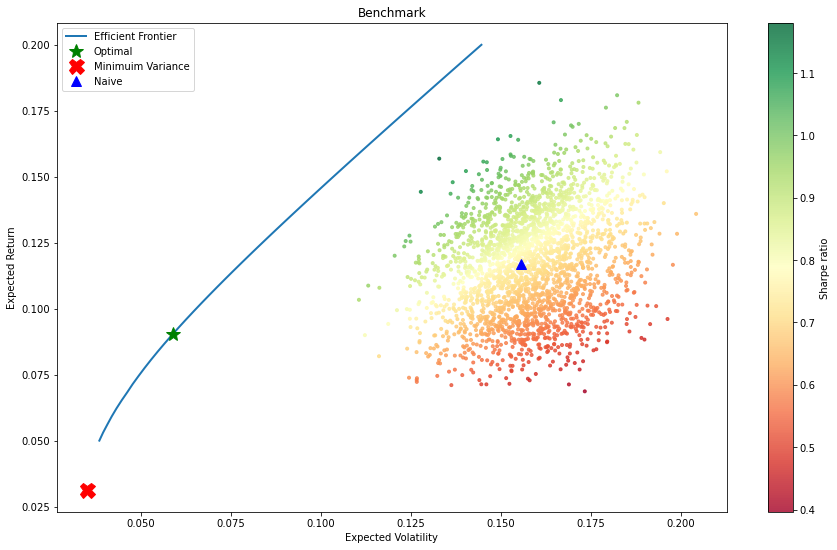

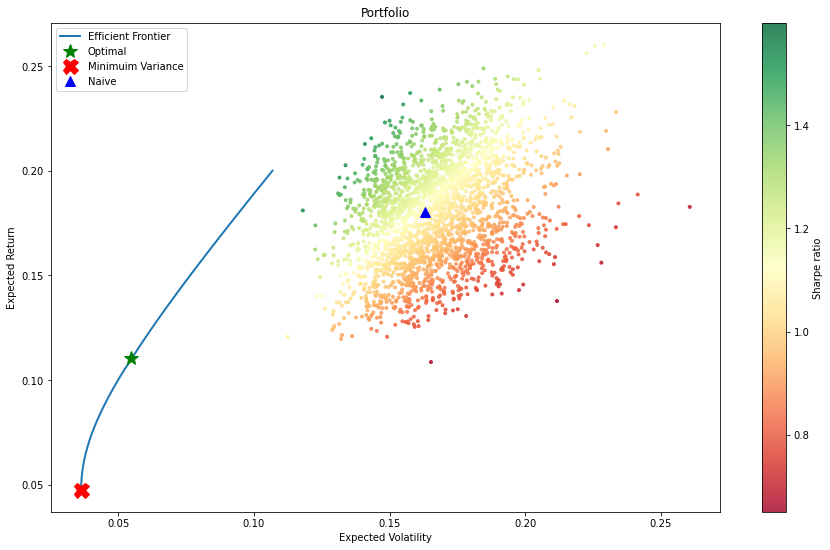

In [18]:
################################################################################################################################
################################                   Generating Graphs                      ######################################
################################################################################################################################

#colormap options PiYG PRGn BrBG PuOr RdGy RdGy RdBu RdYlBu RdYlGn Spectral coolwarm bwr seismic

#plotting the benchmark
plt.figure(figsize=(15,9))
plt.scatter(benchmark_stds,benchmark_returns,c=benchmark_returns/benchmark_stds,marker='.',alpha=0.8,cmap='RdYlGn')
plt.plot(benchmark_target_stds,benchmark_target_returns,'-',lw=2.0,label='Efficient Frontier') #plot efficient frontier
plt.plot(benchmark_opt_std,benchmark_opt_return,'g*',markersize=15.0,label='Optimal') #plot optimal
plt.plot(benchmark_minvar_std,benchmark_minvar_return,'rX',markersize=15.0,label='Minimuim Variance') #plot minvar
plt.plot(benchmark_naive_std,benchmark_naive_return,'b^',markersize=10.0,label='Naive') #plot Naive
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title("Benchmark")
plt.colorbar(label='Sharpe ratio')
plt.legend(bbox_to_anchor=(0,1),loc='upper left',ncol=1)
plt.show()
#plt.plot(x,y)  portfolio

#Plotting the portfolio
plt.figure(figsize=(15,9))
plt.scatter(portfolio_stds,portfolio_returns,c=portfolio_returns/portfolio_stds,marker='.',alpha=0.8,cmap='RdYlGn')
plt.plot(portfolio_target_stds,portfolio_target_returns,'-',lw=2.0,label='Efficient Frontier') #plot efficient frontier
plt.plot(portfolio_opt_std,portfolio_opt_return,'g*',markersize=15.0,label='Optimal') #plot optimal
plt.plot(portfolio_minvar_std,portfolio_minvar_return,'rX',markersize=15.0,label='Minimuim Variance') #plot minvar
plt.plot(portfolio_naive_std,portfolio_naive_return,'b^',markersize=10.0,label='Naive') #plot Naive
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title("Portfolio")
plt.colorbar(label='Sharpe ratio')
plt.legend(bbox_to_anchor=(0,1),loc='upper left',ncol=1)
plt.show()

In [ ]:
################################################################################################################################
################################                 Exporting Data as CSV                    ######################################
################################################################################################################################

benchmark_rets.to_csv("benchreturns.csv") #Generating Benchmark returns data from prices
portfolio_rets.to_csv("portreturns.csv")  #Generating Portfolio returns data from prices
market_rets.to_csv("marketreturns.csv")  #Generating Portfolio returns data from prices

#Generating csv file for Portfolio related CSV Files

portfolio_weights_list_df.to_csv("portfolio_weights_list.csv") #Generating CSV files 
portfolio_returns_df.to_csv("portfolio_returns_df.csv")        #Generating CSV files 
portfolio_stds_df.to_csv("portfolio_stds_df.csv")              #Generating CSV files 
portfolio_betas_df.to_csv("portfolio_betas_df.csv")

#Generating csv file for Benchmark related CSV Files

benchmark_weights_list_df.to_csv("benchmark_weights_list.csv") #Generating CSV files 
benchmark_returns_df.to_csv("benchmark_returns_df.csv")        #Generating CSV files 
benchmark_stds_df.to_csv("benchmark_stds_df.csv")              #Generating CSV files 
benchmark_betas_df.to_csv("benchmark_betas_df.csv")

#Summarizing the data into a single CSV File

benchmark_df.to_csv("benchmark_df.csv") 
portfolio_df.to_csv("portfolio_df.csv")

portfolio_summary_df.to_csv("portfolio_summary_df.csv")
benchmark_summary_df.to_csv("benchmark_summary_df.csv")

#portfolio_data.to_csv("portfoliodata.csv")  #writes a csv file to current location